Проект для «Викишоп» \\
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества F1 не меньше 0.75.

Инструкция по выполнению проекта

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

## Загрузка данных и библиотек

In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
!pip install -q catboost
from catboost import CatBoostClassifier, Pool

import time

from sklearn.metrics import f1_score

from sklearn.model_selection import GridSearchCV, cross_val_score

import warnings
warnings.filterwarnings('ignore')

!pip install -q wordcloud
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [152]:
df = pd.read_csv('toxic_comments.csv')

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [47]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [48]:
df.query('toxic==1').head()

,Unnamed: 0,text,toxic
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,12,Hey... what is it..\n@ | talk .\nWhat is it......,1
16,16,"Bye! \n\nDon't look, come or think of comming ...",1
42,42,You are gay or antisemmitian? \n\nArchangel WH...,1
43,43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1


In [49]:
normal_words = df[df.toxic==0]
toxic_words = df[df.toxic==1]

In [50]:
all_words = " ".join(review for review in df.text)
normal_words = " ".join(review for review in normal_words.text)
toxic_words = " ".join(review for review in toxic_words.text)

In [51]:
wordcloud_all = WordCloud(max_font_size=50, max_words=70, background_color="black").generate(all_words)
wordcloud_normal = WordCloud(max_font_size=50, max_words=70, background_color="black").generate(normal_words)
wordcloud_toxic = WordCloud(max_font_size=50, max_words=70, background_color="black").generate(toxic_words)

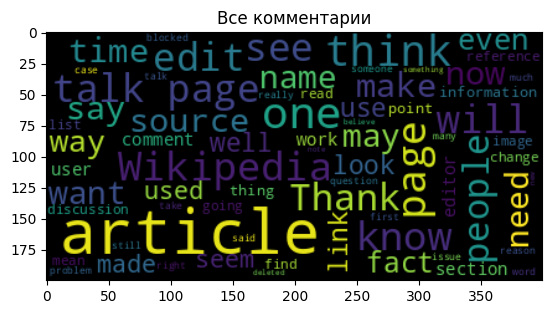

In [9]:
plt.title('Все комментарии');
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.show()

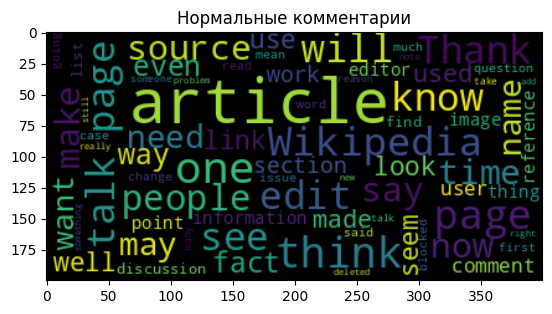

In [10]:
plt.title('Нормальные комментарии')
plt.imshow(wordcloud_normal, interpolation='bilinear')
plt.show()

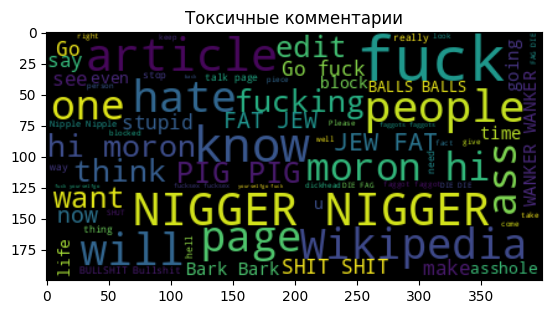

In [11]:
plt.title('Токсичные комментарии')
plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.show()

In [153]:
df['original'] = df['text'].copy()
df = df.reindex(columns=['toxic', 'original', 'text'])

## Подготовка данных

In [154]:
def remove_symbols(text):
    return re.sub(r'[\W\d]\s*', ' ', text).lower()

In [157]:
df.head()

,toxic,original,text
0,0,Explanation\nWhy the edits made under my usern...,explanation why the edits made under my userna...
1,0,D'aww! He matches this background colour I'm s...,d aww he matches this background colour i m se...
2,0,"Hey man, I'm really not trying to edit war. It...",hey man i m really not trying to edit war it s...
3,0,"""\nMore\nI can't make any real suggestions on ...",more i can t make any real suggestions on imp...
4,0,"You, sir, are my hero. Any chance you remember...",you sir are my hero any chance you remember wh...


In [156]:
df.text = df.text.apply(remove_symbols)

In [158]:
def tokenize(text):
    return re.split(' ', text)

In [159]:
df.text = df.text.apply(tokenize)

In [160]:
def remove_empty(text):
    return [word for word in text if word!='']

In [161]:
df.text = df.text.apply(remove_empty)

In [162]:
stopwords_list = stopwords.words('english')
def remove_stopwords(text):
    return [word for word in text if word not in stopwords_list]

In [163]:
df.text = df.text.apply(remove_stopwords)

In [164]:
df_list = df.copy()

In [165]:
df_list.head()

,toxic,original,text
0,0,Explanation\nWhy the edits made under my usern...,"[explanation, edits, made, username, hardcore,..."
1,0,D'aww! He matches this background colour I'm s...,"[aww, matches, background, colour, seemingly, ..."
2,0,"Hey man, I'm really not trying to edit war. It...","[hey, man, really, trying, edit, war, guy, con..."
3,0,"""\nMore\nI can't make any real suggestions on ...","[make, real, suggestions, improvement, wondere..."
4,0,"You, sir, are my hero. Any chance you remember...","[sir, hero, chance, remember, page]"


In [166]:
def make_str(text):
  return ' '.join(text)

In [167]:
df_list.text = df_list.text.apply(make_str)

In [168]:
df_list.head()

,toxic,original,text
0,0,Explanation\nWhy the edits made under my usern...,explanation edits made username hardcore metal...
1,0,D'aww! He matches this background colour I'm s...,aww matches background colour seemingly stuck ...
2,0,"Hey man, I'm really not trying to edit war. It...",hey man really trying edit war guy constantly ...
3,0,"""\nMore\nI can't make any real suggestions on ...",make real suggestions improvement wondered sec...
4,0,"You, sir, are my hero. Any chance you remember...",sir hero chance remember page


In [169]:
# проведём лемматизацию с POS-тегами
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [170]:
# проведём лемматизацию
lemmatizer = WordNetLemmatizer()

def lemm_text(text):
    text = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in nltk.word_tokenize(text)]
    return ' '.join(text)

In [108]:
sentence = "The striped bats are hanging on their feet for best"
print([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)])

['The', 'strip', 'bat', 'be', 'hang', 'on', 'their', 'foot', 'for', 'best']


In [171]:
%%time
df_list.text = df_list.text.apply(lemm_text)

CPU times: user 14min 45s, sys: 44.3 s, total: 15min 29s
Wall time: 15min 38s


In [172]:
df_list.head()

,toxic,original,text
0,0,Explanation\nWhy the edits made under my usern...,explanation edits make username hardcore metal...
1,0,D'aww! He matches this background colour I'm s...,aww match background colour seemingly stuck th...
2,0,"Hey man, I'm really not trying to edit war. It...",hey man really try edit war guy constantly rem...
3,0,"""\nMore\nI can't make any real suggestions on ...",make real suggestion improvement wonder sectio...
4,0,"You, sir, are my hero. Any chance you remember...",sir hero chance remember page


In [173]:
data = df_list.toxic.value_counts()
labels = data.index

Посмотрим на соотношение двух классов: токсичные комментарии и нормальные.

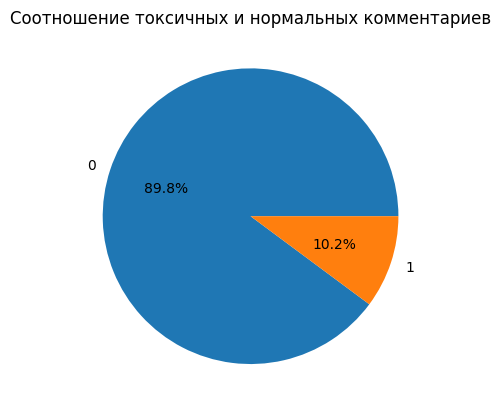

In [174]:
plt.pie(data, labels=labels, autopct='%.1f%%')
plt.title('Соотношение токсичных и нормальных комментариев')
plt.show()

Нормальных комментариев гораздо больше, поэтому нам нужно сначала сбалансировать классы, а потом уже смотреть на метрику f1.

In [175]:
df_list.head()

,toxic,original,text
0,0,Explanation\nWhy the edits made under my usern...,explanation edits make username hardcore metal...
1,0,D'aww! He matches this background colour I'm s...,aww match background colour seemingly stuck th...
2,0,"Hey man, I'm really not trying to edit war. It...",hey man really try edit war guy constantly rem...
3,0,"""\nMore\nI can't make any real suggestions on ...",make real suggestion improvement wonder sectio...
4,0,"You, sir, are my hero. Any chance you remember...",sir hero chance remember page


In [191]:
target = df_list['toxic']
features = df_list.drop(['toxic', 'original'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                              target,
                                                                              test_size=0.4,
                                                                              random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid,
                                                                            target_valid,
                                                                            test_size=0.5,
                                                                            random_state=12345)

In [192]:
features_train.head()

,text
4949,first division include year top tier english f...
101126,electrodeionization history last edit http www...
89090,december post thread wp ani concern talk
9684,deletion discussion list song udit narayan hel...
136885,wikipedia sux rank fagoty as


In [186]:
count_tfidf = TfidfVectorizer(stop_words=stopwords_list)

In [193]:
features_train = count_tfidf.fit_transform(features_train['text'].str.encode('utf8'))
features_valid = count_tfidf.transform(features_valid['text'].str.encode('utf8'))
features_test = count_tfidf.transform(features_test['text'].str.encode('utf8'))

In [194]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(95575, 115496)
(31858, 115496)
(31859, 115496)


**Ресемплирование**

In [195]:
# балансировка target_train
toxic_comments_train = df.iloc[target_train.index]

target_train_class_zero = toxic_comments_train[toxic_comments_train['toxic'] == 0]['toxic']
target_train_class_one = toxic_comments_train[toxic_comments_train['toxic'] == 1]['toxic']

In [196]:
# балансировка features_train
target_train_class_zero_downsample = target_train_class_zero.sample(target_train_class_one.shape[0],
                                                                    random_state=12345)
target_train_downsample = pd.concat([target_train_class_zero_downsample, target_train_class_one])

features_train_downsample = df.iloc[target_train_downsample.index]
features_train_downsample, target_train_downsample = shuffle(features_train_downsample,
                                                             target_train_downsample,
                                                             random_state=12345)
features_train_downsample = count_tfidf.transform(features_train_downsample['text']
                                                   .astype('U'))

In [197]:
# проверка
print(target_train_downsample.shape)
print(features_train_downsample.shape)

(19304,)
(19304, 115496)


In [198]:
# проверка
print(target_train.shape)
print(features_train.shape)

(95575,)
(95575, 115496)


## Обучение

In [204]:
%%time
classificator = LogisticRegression()
hyperparams = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10],
                'class_weight':[{0:1, 1:8.803}]}] #89.8 / 10.2


clf = GridSearchCV(classificator, hyperparams, scoring='f1_macro',cv=4)
clf.fit(features_train, target_train)
LR_best_params = clf.best_params_
print(LR_best_params)
cv_f1_LR = clf.best_score_
print(cv_f1_LR)

{'C': 10, 'class_weight': {0: 1, 1: 8.803}, 'solver': 'newton-cg'}
0.8630744121356425
CPU times: user 2min 25s, sys: 2min 3s, total: 4min 28s
Wall time: 2min 39s


In [205]:
%%time

classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_LR = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_LR)
print('F1 на валидации', valid_f1_LR)

F1 на cv 0.8630744121356425
F1 на валидации 0.7569721115537847
CPU times: user 7 s, sys: 5.25 s, total: 12.2 s
Wall time: 6.34 s


In [206]:
%%time

classificator = DecisionTreeClassifier()
hyperparams = [{'max_depth':[x for x in range(30,51,2)],
                'random_state':[12345],
                'class_weight':[{0:1, 1:8.803}]}]


clf = GridSearchCV(classificator, hyperparams, scoring='f1_macro',cv=4)
clf.fit(features_train, target_train)
DTC_best_params = clf.best_params_
print(DTC_best_params)
cv_f1_DTC = clf.best_score_
print(cv_f1_DTC)

{'class_weight': {0: 1, 1: 8.803}, 'max_depth': 32, 'random_state': 12345}
0.7958382692846016
CPU times: user 23min 36s, sys: 1.43 s, total: 23min 37s
Wall time: 23min 38s


In [207]:
%%time

classificator = DecisionTreeClassifier()
classificator.set_params(**DTC_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_DTC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_DTC)
print('F1 на валидации', valid_f1_DTC)

F1 на cv 0.7958382692846016
F1 на валидации 0.6332522303325223
CPU times: user 24.9 s, sys: 32.4 ms, total: 24.9 s
Wall time: 25 s


In [208]:
%%time

classificator = CatBoostClassifier(verbose=False, iterations=30)
classificator.fit(features_train_downsample, target_train_downsample)
target_predict = classificator.predict(features_valid)
cv_f1_CBC = cross_val_score(classificator,
                                         features_train,
                                         target_train,
                                         cv=4,
                                         scoring='f1_macro').mean()
valid_f1_CBC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_CBC)
print('F1 на валидации', valid_f1_CBC)

F1 на cv 0.8291680106900106
F1 на валидации 0.6822698744769874
CPU times: user 7min 2s, sys: 6.37 s, total: 7min 9s
Wall time: 4min 22s


Лучший результат на кросс-валидации показала логистическая регрессия (0.863), на валидации лучший результат так же у логистической регресии (0.757). Поэтому именно для этой модели мы построим кривую ROC-AUC.

In [209]:
%%time

classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_test)
valid_f1_LR = f1_score(target_test, target_predict)
print('F1 на cv', cv_f1_LR)
print('F1 на валидации', valid_f1_LR)

F1 на cv 0.8630744121356425
F1 на валидации 0.7465963987703118
CPU times: user 7.09 s, sys: 4.96 s, total: 12 s
Wall time: 7.57 s


Значение AUC-ROC =  0.8774390414495805


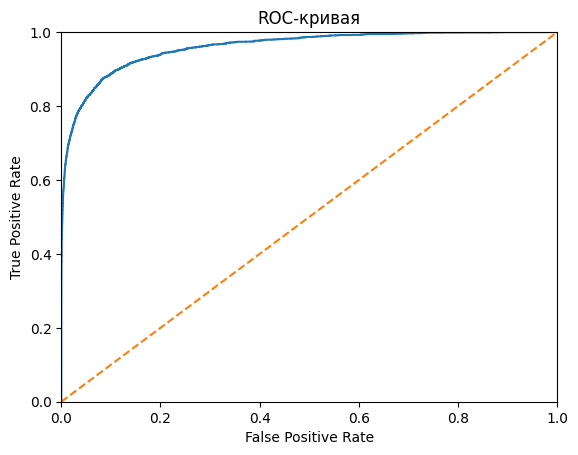

In [210]:
probabilities_test = classificator.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, target_predict)

print('Значение AUC-ROC = ',auc_roc)



fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

## Вывод

Нашей задачей в ходе этого проекта было обучить разные модели классифицировать комментарии на позитивные и токсичные. Данные были выгружены, был проведён анализ, в ходе которого был обнаружен дисбаланс классов. В качестве визуализации двух классов наших комментариев была выбрана библиотека WordCloud. Далее была произведена лемматизация текста комментариев. В качестве изучаемых моделей были выбраны логистическая регрессия, дерево решений и CatBoost. При их обучении мы учитывали дисбаланс классов. Наилучший результат показала логистическая регрессия (на кросс-валидации: 0.863, на валидации: 0.757, на тесте: 0.747). Затем мы построили кривую ROC-AUC (площадь под графиком равна 0.877).
